In [3]:
import clip
import json
import os
import torch
import trimesh
import time
import optuna
from torchvision.transforms import Compose, Normalize, Resize, CenterCrop, InterpolationMode
import multiprocess
import math
from functools import partial
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
#model, preprocess = clip.load("ViT-B/32", device=device)

In [2]:
print('Number of cpus: ', multiprocess.cpu_count())

Number of cpus:  4


## Rendering Setup

In [3]:
# --- Hyperparameter Setup ---

hparams = {
    # Camera
    "camera_distance_factor": 0.45,
    "camera_angle": 55.,
    "focal_length": 3.15,
    # Image
    "resolution": 300,
    # Phong
    "ambient_coeff": 0.67,
    "diffuse_coeff": 0.79,
    "specular_coeff": 0.63,
    "shininess": 1.0,
    # Colors
    "object_color": torch.tensor([0.63, 0.17, 0.78]),
    "background_color": torch.tensor([0.35, 0.94, 0.26]),
    # Light
    "amb_light_color": torch.tensor([0.57, 0.07, 0.69]),
    # light 1
    "light_intensity_1": 2.247, 
    "light_color": torch.tensor([0.88, 0.99, 0.74]), 
    "light_dir_1": torch.tensor([-0.410, -0.506, -0.759]), 
    # light p
    "light_intensity_p": 0.,
    "light_radius_p": 2., 
    "light_u1_p": 0.5,
    "light_u2_p": 0.5
}

# --- Rendering Function ---

def phong_model(sdf, points, camera_position, phong_params, light_params, mesh_path, index_tri=None):
    
    # Option 1: Use SDF
    #normals = estimate_normals(sdf, points)
    # Option 2: Use Mesh
    normals = mesh_normals(mesh_path, index_tri)
    view_dirs = points - camera_position 
    light_dir_1 = light_params["light_dir_1"].repeat(points.shape[0], 1) 
    light_dir_p = points - light_params["light_pos_p"].repeat(points.shape[0], 1)
    
    # Normalize all vectors
    normals = (normals.T / torch.norm(normals, dim=-1)).T
    light_dir_norm_1 = (light_dir_1.T / torch.norm(light_dir_1, dim=-1)).T
    light_dir_norm_p = (light_dir_p.T / torch.norm(light_dir_p, dim=-1)).T
    view_dir_norm = (view_dirs.T / torch.norm(view_dirs, dim=-1)).T
    
    # Ambient
    ambient = phong_params["ambient_coeff"] * light_params["amb_light_color"] 
    ambient_refl = ambient.repeat(points.shape[0], 1)
    
    # Area light
    diffuse_1 = phong_params["diffuse_coeff"] * torch.clamp(torch.sum(-light_dir_norm_1 * normals, dim=-1), min=0.0) * light_params["light_intensity_1"] # [N]
    diffuse_refl_1 = torch.matmul(diffuse_1.unsqueeze(1), light_params["light_color_1"].unsqueeze(0)) # [N, 3]
    reflect_dir_1 = light_dir_norm_1 + (2 * normals.T * torch.clamp(torch.sum(-light_dir_norm_1 * normals, dim=-1), min=0.0)).T
    specular_1 = phong_params["specular_coeff"] * torch.pow(torch.clamp(torch.sum(reflect_dir_1 * -view_dir_norm, dim=-1), min=0.0), phong_params["shininess"]) * light_params["light_intensity_1"] # [N]
    specular_refl_1 = torch.matmul(specular_1.unsqueeze(1), light_params["light_color_1"].unsqueeze(0)) # [N, 3]
    
    
    # Point light
    diffuse_p = phong_params["diffuse_coeff"] * torch.clamp(torch.sum(-light_dir_norm_p * normals, dim=-1), min=0.0) * light_params["light_intensity_p"]  # [N]
    diffuse_refl_p = torch.matmul(diffuse_p.unsqueeze(1), light_params["light_color_p"].unsqueeze(0)) # [N, 3]
    reflect_dir_p = light_dir_norm_p + (2 * normals.T * torch.clamp(torch.sum(-light_dir_norm_p * normals, dim=-1), min=0.0)).T
    specular_p = phong_params["specular_coeff"] * torch.pow(torch.clamp(torch.sum(reflect_dir_p * -view_dir_norm, dim=-1), min=0.0), phong_params["shininess"]) * light_params["light_intensity_p"] # [N]
    specular_refl_p = torch.matmul(specular_p.unsqueeze(1), light_params["light_color_p"].unsqueeze(0)) # [N, 3]


    return ambient_refl + diffuse_refl_1 + specular_refl_1 + diffuse_refl_p + specular_refl_p 

def estimate_normals(sdf, points, epsilon=1e-3):
    sdf_inputs = torch.concat([points,
                              points + torch.tensor([epsilon, 0, 0]),
                              points + torch.tensor([0, epsilon, 0]),
                              points + torch.tensor([0, 0, epsilon])])

    sdf_values = sdf(sdf_inputs).reshape(4, -1)

    # Calculate the gradient using finite differences
    gradient = sdf_values[1:] - sdf_values[0]

    # Normalize the gradient to obtain the estimated normal
    normal = gradient / torch.norm(gradient, p=2, dim=0)

    return normal.T

def sphere_trace(sdf, camera_position, norm_directions, max_length):
    N = norm_directions.shape[0]
    positions = camera_position.unsqueeze(dim=0).repeat(N, 1) # [N, 3]
    total_distances = torch.zeros(N)
    last_distances = torch.ones(N)

    for _ in range(20):
        #mask = torch.logical_and(total_distances < max_length, last_distances > 1e-3)
        not_reached_max_distance = total_distances < max_length
        not_hit_target = torch.abs(last_distances) > 1e-3
        mask = torch.logical_and(not_reached_max_distance, not_hit_target)
        if torch.all(torch.logical_not(mask)):
            break
        distances = sdf(positions[mask])
        steps = (norm_directions[mask].T * distances).T
        positions[mask] += steps
        total_distances[mask] += distances
        last_distances[mask] = distances

    #positions[total_distances > max_length] *= torch.nan
    return positions, total_distances < max_length

def mesh_trace(mesh_path, ray_starts, ray_directions):
    mesh = trimesh.load_mesh(mesh_path)
    
    ray_origins = ray_starts.repeat(ray_directions.shape[0], 1)
    
    intersections, index_ray, index_tri = mesh.ray.intersects_location(ray_origins, ray_directions, multiple_hits=False) 
    
    mask = torch.zeros(ray_directions.shape[0], dtype=torch.bool)
    mask[index_ray] = True
    
    points = torch.as_tensor(intersections, dtype=torch.float32)

    return points, mask, index_tri


def mesh_normals(mesh_path, index_tri):
    mesh = trimesh.load_mesh(mesh_path)
    all_normals = mesh.face_normals
    normals = all_normals[index_tri]
    normals_torch = torch.from_numpy(normals).to(dtype=torch.float32)
    
    return normals_torch

def render(model, lat_rep, camera_params, phong_params, light_params, mesh_path=None):
    
    def sdf(positions):
        nphm_input = torch.reshape(positions, (1, -1, 3))
        distance, _ = model(nphm_input, torch.reshape(lat_rep, (1, 1, -1)), None)
        return distance.squeeze()

    pu = camera_params["resolution_x"]
    pv = camera_params["resolution_y"]
    image = phong_params["background_color"].repeat(pu * pv, 1)
    
    angle_radians = torch.deg2rad_(torch.tensor(camera_params["camera_angle"]))
    camera = torch.tensor([torch.sin(angle_radians), 0, torch.cos(angle_radians)])
    camera_position = camera * (camera_params["camera_distance"] + camera_params["focal_length"]) / camera.norm()
    
    # Normalize the xy value of the current pixel [-0.5, 0.5]
    u_norms = ((torch.arange(pu) + 0.5) / pu - 0.5) * pu/pv
    v_norms = 0.5 - (torch.arange(pv) + 0.5) / pv

    # Calculate the ray directions for all pixels
    directions_unn = torch.cat(torch.meshgrid(u_norms, v_norms, torch.tensor(-camera_params["focal_length"]), indexing='ij'), dim=-1) 
    directions_unn = directions_unn.reshape((pu*pv, 3)) # [pu, pv, 3] --> [pu*pv, 3] (u1, v1, f)(u1, v2, f)...(u2, v1, f)...

    # rotate about y-axis
    rotation_matrix = torch.tensor([[torch.cos(angle_radians), 0, torch.sin(angle_radians)],
                                    [0, 1, 0],
                                    [-torch.sin(angle_radians), 0, torch.cos(angle_radians)]])
    rotated_directions = torch.matmul(directions_unn, rotation_matrix.T)
    
    transposed_directions = rotated_directions.T #transpose is necessary for normalization
    directions = (transposed_directions / transposed_directions.norm(dim=0)).T # [pu*pv, 3]

    # Option 1: Use SDF
    #hit_positions, hit_mask = sphere_trace(sdf, camera_position, directions, camera_params['max_ray_length'])
    # Option 2: Use Mesh
    intersections, hit_mask, index_tri = mesh_trace(mesh_path, camera_position, directions) 
    
    # Option 1: Use SDF
    #reflections = phong_model(sdf, hit_positions[hit_mask], camera_position, phong_params, light_params, mesh_path)
    # Option 2: Use Mesh
    reflections = phong_model(sdf, intersections, camera_position, phong_params, light_params, mesh_path, index_tri) # mesh alternative

    # Assign a color for objects
    image[hit_mask] = torch.mul(reflections, phong_params["object_color"].repeat(reflections.shape[0], 1))
    image = torch.clamp(image, max=1.0)
    image = image.reshape(pu, pv, 3).transpose(0, 1)


    return image

## Prepare Score Calculation Data

In [4]:
# --- Get Data Annotations ---

path_to_head_annotations = '/Users/katharinaschmid/Text2Head/rendering_data/head_annotations.json'
with open(path_to_head_annotations) as f:
    data = json.load(f)

# --- Prepare Indices ---

# Identity: Gender
male_indices = [index for index, head in enumerate(data['heads']) if head['gender'] == 'man']
female_indices = [index for index, head in enumerate(data['heads']) if head['gender'] == 'woman']

# Identity: Age
young_indices = [index for index, head in enumerate(data['heads']) if head['age'] == 'young']
old_indices = [index for index, head in enumerate(data['heads']) if head['age'] == 'old']

# Identity: Ethnicity
caucasian_indices = [index for index, head in enumerate(data['heads']) if head['ethnicity'] == 'Caucasian'] 
asian_indices = [index for index, head in enumerate(data['heads']) if head['ethnicity'] == 'Asian'] 

# Identity: Hairstyle
hat_indices = [index for index, head in enumerate(data['heads']) if head['hairstyle'] == 'hat']
ponytail_indices = [index for index, head in enumerate(data['heads']) if head['hairstyle'] == 'ponytail']
straight_hair_indices = [index for index, head in enumerate(data['heads']) if head['hairstyle'] == 'straight hair']
curly_hair_indices = [index for index, head in enumerate(data['heads']) if head['hairstyle'] == 'curly hair']

# Identity: Beard
beard_indices = [index for index, head in enumerate(data['heads']) if head['beard'] == 'yes']
no_beard_indices = [index for index, head in enumerate(data['heads']) if head['beard'] == 'no']

# Expression: Facial Expression
open_mouth_indices = [index for index, head in enumerate(data['heads']) if head['facial_expression'] == 'open mouth']
smiling_indices = [index for index, head in enumerate(data['heads']) if head['facial_expression'] == 'smiling']
closed_eyes_indices = [index for index, head in enumerate(data['heads']) if head['facial_expression'] == 'closed eyes']
raised_brows_indices = [index for index, head in enumerate(data['heads']) if head['facial_expression'] == 'raised brows']
puffed_cheeks_indices = [index for index, head in enumerate(data['heads']) if head['facial_expression'] == 'puffed cheeks']

# Expression: Emotion 
sad_indices = [index for index, head in enumerate(data['heads']) if head['emotion'] == 'sad']
not_sad_indices = [index for index, head in enumerate(data['heads']) if head['emotion'] != 'sad']
happy_indices = [index for index, head in enumerate(data['heads']) if head['emotion'] == 'happy']
not_happy_indices = [index for index, head in enumerate(data['heads']) if head['emotion'] != 'happy']

# --- Precompute CLIP Text Embeddings ---
captions = []
captions.append('A man') # 0
captions.append('A woman') # 1
captions.append('A young person') # 2
captions.append('An old person') # 3
captions.append('A Caucasian person') # 4
captions.append('An Asian person') # 5
captions.append('An African person') # 6
captions.append('A person wearing a hat') # 7
captions.append('A person with a ponytail') # 8
captions.append('A person with straight hair') # 9
captions.append('A person with curly hair') # 10
captions.append('A person with beard') # 11
captions.append('A person with open mouth') # 12
captions.append('A smiling person') # 13
captions.append('A person with closed eyes') # 14
captions.append('A frowning person') # 15
captions.append('A person with puffed cheeks') # 16
captions.append('A sad person') # 17
captions.append('A happy person') # 18

preprocessed_text = clip.tokenize(captions).to(device) # [num_captions, 77]

with torch.no_grad():
    text_features = model.encode_text(preprocessed_text) # [num_captions, 512]
    text_features /= text_features.norm(dim=-1, keepdim=True) # [num_captions, 512]

## Hyperparameter Search for Renderer

In [7]:
# --- CLIP Preprocessing --- # 
clip_tensor_preprocessor = Compose([
    Resize(224, interpolation=InterpolationMode.BICUBIC, antialias=None),
    CenterCrop(224),
    Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
])


# --- Penalty Function to penalize negative Signal Scores ---
def penalty(vector, k):
    vector[vector < 0] *= k
    return vector

# --- Image Embedding Function for Parallel Processing ---

def get_image_embeddings(mesh_path, camera_params, phong_params, light_params):
    sdf = None
    lat_rep = None
    rendered_image = render(sdf, lat_rep, camera_params, phong_params, light_params, mesh_path)
    image_c_first = rendered_image.permute(2, 0, 1)
    image_preprocessed = clip_tensor_preprocessor(image_c_first).unsqueeze(0)
    image_features = model.encode_image(image_preprocessed) # [1, 512]
    
    return image_features

def analyze_rendering(hparams):
    
    # --- Get Hyperparameters ---
    camera_params = {
        "camera_distance": hparams['camera_distance_factor'] * hparams['focal_length'], # ensures appropriate head size
        "camera_angle": hparams['camera_angle'],
        "focal_length": hparams['focal_length'],
        "max_ray_length": (hparams['camera_distance_factor'] + 1) * hparams['focal_length'] + 1.5,
        # Image
        "resolution_y": hparams['resolution'],
        "resolution_x": hparams['resolution']
    }
    phong_params = {
        "ambient_coeff": hparams['ambient_coeff'],
        "diffuse_coeff": hparams['diffuse_coeff'],
        "specular_coeff": hparams['specular_coeff'],
        "shininess": hparams['shininess'],
        # Colors
        "object_color": hparams['object_color'],
        "background_color": hparams['background_color']
    }
    
    light_params = {
        "amb_light_color": hparams['amb_light_color'],
        # light 1
        "light_intensity_1": hparams['light_intensity_1'],
        "light_color_1": hparams['light_color'],
        "light_dir_1": hparams['light_dir_1'],
        # light p
        "light_intensity_p": hparams['light_intensity_p'],
        "light_color_p": hparams['light_color'],
        "light_pos_p": torch.tensor([hparams['light_radius_p'] * math.sqrt(1 - hparams['light_u1_p']**2) * math.cos(2*math.pi*hparams['light_u2_p']),
                                     hparams['light_radius_p'] * math.sqrt(1 - hparams['light_u1_p']**2) * math.sin(2*math.pi*hparams['light_u2_p']), 
                                     hparams['light_radius_p'] * hparams['light_u1_p']])
    }
    
    # --- Render and Embed Images ---
    folder_path = '/Users/katharinaschmid/Text2Head/rendering_data/annotated_dataset/'
    file_list = sorted(os.listdir(folder_path))
    file_list = [file for file in file_list if not (file.startswith('.DS_Store') or file.endswith('.png'))]
    
    one_mesh_path = folder_path + file_list[0]
    sdf = None
    lat_rep = None
    rendered_image = render(sdf, lat_rep, camera_params, phong_params, light_params, one_mesh_path)
    plt.imshow(rendered_image.detach().numpy())
    plt.axis('off')  # Turn off axes
    plt.show()
    
    mesh_path_list = []
    for mesh in file_list:
        mesh_path_list.append(folder_path + mesh)
        
    with torch.no_grad():
        pool = multiprocess.Pool(processes=None)
        simplified_func = partial(get_image_embeddings, camera_params=camera_params, phong_params=phong_params, light_params=light_params) # creates a simplified version of the function 'get_image_embeddings' where certain arguments are fixed to specific values
        image_embeddings_list = pool.map(simplified_func, mesh_path_list)

        image_embeddings = torch.cat(image_embeddings_list, dim=0)
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)
        
        # --- Get CLIP Similarity and Scores ---
        cosine_similarity = torch.matmul(text_features, image_embeddings.T) #[num_captions*tests, num_images]
        
        # Identity Scores
        i_man_score = torch.mean(cosine_similarity[0, male_indices], dim=-1) - torch.mean(cosine_similarity[0, female_indices], dim=-1)
        i_woman_score = torch.mean(cosine_similarity[1, female_indices], dim=-1) - torch.mean(cosine_similarity[1, male_indices], dim=-1)
        
        i_young_score = torch.mean(cosine_similarity[2, young_indices], dim=-1) - torch.mean(cosine_similarity[2, old_indices], dim=-1)
        i_old_score = torch.mean(cosine_similarity[3, old_indices], dim=-1) - torch.mean(cosine_similarity[3, young_indices], dim=-1)
        i_caucasian_score = torch.mean(cosine_similarity[4, caucasian_indices], dim=-1) - torch.mean(cosine_similarity[4, (asian_indices)], dim=-1)
        i_asian_score = torch.mean(cosine_similarity[5, asian_indices], dim=-1) - torch.mean(cosine_similarity[5, (caucasian_indices)], dim=-1)
        # 6 skip african
        i_hat_score = torch.mean(cosine_similarity[7, hat_indices], dim=-1) - torch.mean(cosine_similarity[7, (ponytail_indices + straight_hair_indices + curly_hair_indices)], dim=-1)
        i_ponytail_score = torch.mean(cosine_similarity[8, ponytail_indices], dim=-1) - torch.mean(cosine_similarity[8, (hat_indices + straight_hair_indices + curly_hair_indices)], dim=-1)
        i_straight_hair_score = torch.mean(cosine_similarity[9, straight_hair_indices], dim=-1) - torch.mean(cosine_similarity[9, curly_hair_indices], dim=-1) # ONLY curly hair as opposite!
        i_curly_hair_score = torch.mean(cosine_similarity[10, curly_hair_indices], dim=-1) - torch.mean(cosine_similarity[10, straight_hair_indices], dim=-1) # ONLY straight hair as opposite!
        i_beard_score = torch.mean(cosine_similarity[11, beard_indices], dim=-1) - torch.mean(cosine_similarity[11, no_beard_indices], dim=-1)
        
        # Expression Scores
        e_open_mouth_score = torch.mean(cosine_similarity[12, open_mouth_indices], dim=-1) - torch.mean(cosine_similarity[12, (closed_eyes_indices + raised_brows_indices + puffed_cheeks_indices)], dim=-1) # no smiling as opposite b/c mouth can be open when grinning
        e_smiling_score = torch.mean(cosine_similarity[13, smiling_indices], dim=-1) - torch.mean(cosine_similarity[13, (open_mouth_indices + closed_eyes_indices + raised_brows_indices + puffed_cheeks_indices)], dim=-1)
        e_closed_eyes_score = torch.mean(cosine_similarity[14, closed_eyes_indices], dim=-1) - torch.mean(cosine_similarity[14, (open_mouth_indices + smiling_indices + raised_brows_indices + puffed_cheeks_indices)], dim=-1)
        e_raised_brows_score = torch.mean(cosine_similarity[15, raised_brows_indices], dim=-1) - torch.mean(cosine_similarity[15, (open_mouth_indices + smiling_indices + closed_eyes_indices + puffed_cheeks_indices)], dim=-1)
        e_puffed_cheeks_score = torch.mean(cosine_similarity[16, puffed_cheeks_indices], dim=-1) - torch.mean(cosine_similarity[16, (open_mouth_indices + smiling_indices + closed_eyes_indices + raised_brows_indices)], dim=-1)
        e_sad_score = torch.mean(cosine_similarity[17, sad_indices], dim=-1) - torch.mean(cosine_similarity[17, not_sad_indices], dim=-1)
        e_happy_score = torch.mean(cosine_similarity[18, happy_indices], dim=-1) - torch.mean(cosine_similarity[18, not_happy_indices], dim=-1)
        
        # Stack Scores, add penalty, compute average
        i_scores = torch.stack((i_man_score, i_woman_score, i_young_score, i_old_score, i_caucasian_score, i_asian_score, i_hat_score, i_ponytail_score, i_straight_hair_score, i_curly_hair_score, i_beard_score), dim=0)
        e_scores = torch.stack((e_open_mouth_score, e_smiling_score, e_closed_eyes_score, e_raised_brows_score, e_puffed_cheeks_score, e_sad_score, e_happy_score), dim=0)
        print('i_scores: ', i_scores, 'e_scores: ', e_scores)
        scores = torch.cat((i_scores, e_scores), dim=0)
        scores_penalized = penalty(scores, 10)
        scores_avg = torch.mean(scores_penalized, dim=0)
        print('scores penalized: ', scores_penalized)
        print('scores_avg: ', scores_avg)
        
    
    return scores_avg

def objective(trial):
    # Define the hyperparameters to tune and their search spaces
    search_space = {
        # Camera
        "camera_distance_factor": trial.suggest_float('camera_distance_factor', 0.2, 0.5), 
        "camera_angle": trial.suggest_categorical('camera_angle', [30., 45., 55.]), 
        "focal_length": trial.suggest_float('focal_length', 1.0, 4.0),
        # Phong
        "ambient_coeff": trial.suggest_float('ambient_coeff', 0.3, 0.8), 
        "diffuse_coeff": trial.suggest_float('diffuse_coeff', 0.6, 1.0), 
        "specular_coeff": trial.suggest_float('specular_coeff', 0.4, 0.7), 
        "shininess": trial.suggest_categorical('shininess', [0.1, 0.5, 1.0, 3.0]),
        # Colors
        "object_color": torch.tensor([
            trial.suggest_float('object_color_0', 0.5, 1.0),
            trial.suggest_float('object_color_1', 0.0, 0.4),
            trial.suggest_float('object_color_2', 0.6, 1.0)
        ]),
        "background_color": torch.tensor([
            trial.suggest_float('background_color_0', 0.0, 0.4),
            trial.suggest_float('background_color_1', 0.6, 1.0),
            trial.suggest_float('background_color_2', 0.0, 0.4)
        ]),
        # Light
        "amb_light_color": torch.tensor([
            trial.suggest_float('amb_light_color_0', 0.3, 0.9),
            trial.suggest_float('amb_light_color_1', 0.0, 0.3),
            trial.suggest_float('amg_light_color_2', 0.4, 0.8)
        ]),
        # light 1
        "light_intensity_1": trial.suggest_float('light_intensity_1', 1.0, 3.0), 
        "light_color": torch.tensor([
            trial.suggest_float('light_color_0', 0.8, 1.0),
            trial.suggest_float('light_color_1', 0.9, 1.0),
            trial.suggest_float('light_color_2', 0.7, 0.9)
        ]),
        "light_dir_1": torch.tensor([
            trial.suggest_float('light_dir_1_0', -0.6, -0.2),
            trial.suggest_float('light_dir_1_1', -0.7, -0.3),
            trial.suggest_float('light_dir_1_2', -0.95, -0.55)
        ]),
        # light p
        "light_intensity_p": trial.suggest_float('light_intensity_p', 0., 2.), 
        "light_radius_p": trial.suggest_float('light_radius_p', 1., 4.), 
        "light_u1_p": trial.suggest_float('light_u1_p', -1.0, 1.0),
        "light_u2_p": trial.suggest_float('light_u2_p', 0., 1.)
    }
    
    hparams.update(search_space)
    
    return analyze_rendering(hparams)

[I 2023-12-04 12:54:49,778] Using an existing study with name 'render_params_update2' instead of creating a new one.


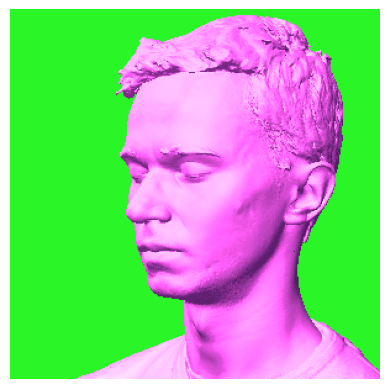

i_scores:  tensor([ 0.0226,  0.0267,  0.0100,  0.0063, -0.0096,  0.0392,  0.0336,  0.0254,
         0.0026,  0.0162,  0.0225]) e_scores:  tensor([ 0.0247,  0.0320,  0.0115, -0.0002,  0.0140,  0.0069,  0.0285])
scores penalized:  tensor([ 0.0226,  0.0267,  0.0100,  0.0063, -0.0958,  0.0392,  0.0336,  0.0254,
         0.0026,  0.0162,  0.0225,  0.0247,  0.0320,  0.0115, -0.0017,  0.0140,
         0.0069,  0.0285])
scores_avg:  tensor(0.0125)


[I 2023-12-04 13:03:13,411] Trial 5 finished with value: 0.012514243833720684 and parameters: {'camera_distance_factor': 0.25726621886843837, 'camera_angle': 45.0, 'focal_length': 3.9646102549351676, 'ambient_coeff': 0.3938985635816278, 'diffuse_coeff': 0.9689532599694787, 'specular_coeff': 0.6729773520548883, 'shininess': 1.0, 'object_color_0': 0.7149077730433033, 'object_color_1': 0.2474139579741023, 'object_color_2': 0.7873451426603383, 'background_color_0': 0.16140986125949974, 'background_color_1': 0.9623644696726469, 'background_color_2': 0.15614810547253458, 'amb_light_color_0': 0.3506800674897274, 'amb_light_color_1': 0.23846947527899087, 'amg_light_color_2': 0.6883675213462679, 'light_intensity_1': 1.5603712117990438, 'light_color_0': 0.934829994903975, 'light_color_1': 0.9942709837193014, 'light_color_2': 0.7002996467385642, 'light_dir_1_0': -0.47545870283447056, 'light_dir_1_1': -0.5195233243528551, 'light_dir_1_2': -0.7497624381885439, 'light_intensity_p': 1.454036711343930

{'camera_distance_factor': 0.24412803855674434, 'camera_angle': 45.0, 'focal_length': 1.3809421636277768, 'ambient_coeff': 0.3390605286346622, 'diffuse_coeff': 0.7443970010205765, 'specular_coeff': 0.6276260662406582, 'shininess': 0.1, 'object_color_0': 0.6680438364230581, 'object_color_1': 0.26068118571380716, 'object_color_2': 0.6806486770978691, 'background_color_0': 0.3481958083339456, 'background_color_1': 0.9186302837310005, 'background_color_2': 0.23910043025842806, 'amb_light_color_0': 0.4142143655160655, 'amb_light_color_1': 0.023941594107037365, 'amg_light_color_2': 0.4570449506191847, 'light_intensity_1': 1.5652920283440128, 'light_color_0': 0.8910584472379374, 'light_color_1': 0.9818810282290378, 'light_color_2': 0.8301530934745256, 'light_dir_1_0': -0.39949317375065524, 'light_dir_1_1': -0.4944900339685992, 'light_dir_1_2': -0.8642384888368425, 'light_intensity_p': 1.7583288190170565, 'light_radius_p': 2.6418666444208507, 'light_u1_p': 0.2582979656315163, 'light_u2_p': 0.7

In [10]:
if __name__ == '__main__':
    study = optuna.create_study(storage="sqlite:///optuna_study_renderparams.db", study_name="render_params_update2", direction='maximize', load_if_exists=True)
    study.optimize(objective, n_trials=1)
        
    best_params = study.best_params
    print(best_params)